In [45]:

import os

import joblib
import pandas as pd

os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1. / 255)

valid_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.4)

In [47]:
SAVE_DIR = "/Users/Bilal/PycharmProjects/LearningAI/models/assignment_7/task_3"
MODEL_PATH = f"{SAVE_DIR}/food_model_feature_extraction.keras"
HISTORY_PATH = f"{SAVE_DIR}/history_feature_extraction.pkl"

In [48]:
train_dir = "/Users/Bilal/PycharmProjects/LearningAI/Files/assignment_7/task_3/10_food_classes_all_data/train"
test_dir = "/Users/Bilal/PycharmProjects/LearningAI/Files/assignment_7/task_3/10_food_classes_all_data/test"

In [49]:

train_data = train_datagen.flow_from_directory(
    train_dir,
    color_mode="rgb",
    batch_size=32,
    target_size=(224, 224),
    class_mode="categorical"
)

validation_data = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

test_data = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=False
)

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

Found 7500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


In [50]:
IMAGE_SHAPE = (224, 224)

In [51]:
feature_extractor_layer = hub.KerasLayer(
    efficientnet_url,
    trainable=False,
    name="feature_extraction_layer",
    input_shape=IMAGE_SHAPE + (3,)
)

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(10, activation="softmax", name="output_layer")
])


In [52]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [53]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)


Making a new Model
Epoch 1/5
235/235 [==============================] - ETA: 0s - loss: 0.8079 - accuracy: 0.7733
Epoch 1: val_accuracy improved from -inf to 0.89700, saving model to /Users/Bilal/PycharmProjects/LearningAI/models/assignment_7/task_3/food_model_feature_extraction.keras
235/235 [==============================] - 63s 253ms/step - loss: 0.8079 - accuracy: 0.7733 - val_loss: 0.3900 - val_accuracy: 0.8970
Epoch 2/5
235/235 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8660
Epoch 2: val_accuracy improved from 0.89700 to 0.90300, saving model to /Users/Bilal/PycharmProjects/LearningAI/models/assignment_7/task_3/food_model_feature_extraction.keras
235/235 [==============================] - 63s 266ms/step - loss: 0.4458 - accuracy: 0.8660 - val_loss: 0.3195 - val_accuracy: 0.9030
Epoch 3/5
235/235 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8863
Epoch 3: val_accuracy improved from 0.90300 to 0.91200, saving model to /Users/Bi

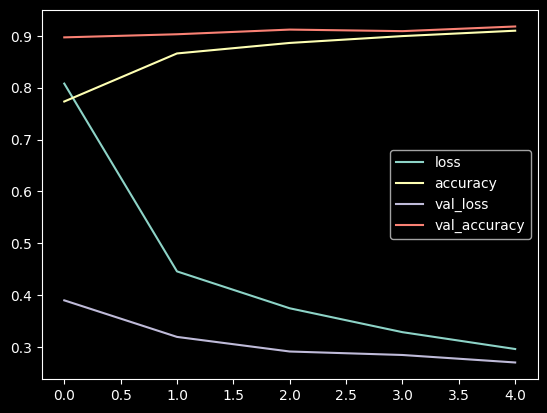

In [54]:

if os.path.exists(MODEL_PATH) and os.path.exists(HISTORY_PATH):
    print("Loading Already Present Model")
    model = tf.keras.models.load_model(
        MODEL_PATH,
        custom_objects={'KerasLayer': hub.KerasLayer}
    )
    history = joblib.load(HISTORY_PATH)
    #evaulation
    pd.DataFrame(history).plot()

else:
    print("Making a new Model")

    history = model.fit(train_data, epochs=5, validation_data=validation_data, callbacks=[checkpoint])
    model.save(MODEL_PATH)
    #savng history
    joblib.dump(history.history, HISTORY_PATH)

    #evaluation
    pd.DataFrame(history.history).plot()

In [55]:
y_prob = model.predict(test_data)

# Convert probabilities to class index
y_pred = y_prob.argmax(axis=1)

# True labels
y_true = test_data.classes


47/47 [==============================] - 11s 225ms/step


In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

                precision    recall  f1-score   support

 chicken_curry       0.88      0.85      0.86       150
 chicken_wings       0.94      0.93      0.94       150
    fried_rice       0.92      0.89      0.91       150
grilled_salmon       0.84      0.85      0.84       150
     hamburger       0.94      0.93      0.94       150
     ice_cream       0.95      0.97      0.96       150
         pizza       1.00      0.97      0.99       150
         ramen       0.91      0.95      0.93       150
         steak       0.84      0.91      0.87       150
         sushi       0.95      0.92      0.94       150

      accuracy                           0.92      1500
     macro avg       0.92      0.92      0.92      1500
  weighted avg       0.92      0.92      0.92      1500

